In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import shutil as sh
import os
import time
import random

In [ ]:
print(torch.cuda.is_available())

print(torch.cuda.current_device())

Configuration of hyperparams and other variables that will be used later

In [ ]:
img_size = 224

batch_size = 128
learning_rate = 1e-3
num_epochs = 1
dropout = 0.3
convolutional_kernel = 4
max_pool_kernel = 4

amount_of_pictures_to_show = 10

classification_batch_size = 128
classification_learning_rate = 1e-3
classification_epochs = 20

encoder_name = "encoder_1_epoch.pth"
decoder_name = "decoder_1_epoch.pth"
autoencoder_name = "autoencoder_1_epoch.pth"
classifier_name = "classifier.pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

workers = os.cpu_count() - 2
print(f"Using {workers} workers for loading the datasets")

Using device cuda:0
Using 14 workers for loading the datasets


### Fixing the food-101 dataset structure

In [ ]:
def fixFood101(path: str):
    if os.path.exists(path):
        if os.path.exists(path + "/images/test/"):
            print("The structure is already fixed!")
            return
        
        file = open(path + "/meta/train.txt")
        list = file.readlines()
        file.close()

        for item in list:
            os.makedirs(path + "/images/train/"+item.split("/")[0], exist_ok=True)
            sh.move(path + "/images/"+item[:-1]+".jpg", path + "/images/train/"+item[:-1]+".jpg")

        file = open(path + "/meta/test.txt")
        list = file.readlines()
        file.close()

        for item in list:
            os.makedirs(path + "/images/test/"+item.split("/")[0], exist_ok=True)
            sh.move(path + "/images/"+item[:-1]+".jpg", path + "/images/test/"+item[:-1]+".jpg")

        for dirPath, _, _ in os.walk(path + "/images/"):
            try:
                os.rmdir(dirPath)
            except:
                pass
    else:
        print("Couldn't find food-101")
fixFood101("./Datasets/food-101")

### Preprocessing function

In [ ]:
def preprocess(org_path: str, train: bool):
    arr = org_path.split("/")
    dst_start = "/".join(arr[:arr.index("Datasets") + 1])
    dst = ""
    if train:
        dst = dst_start + "/Cleaned/train/" + "/".join(org_path.split("/")[-2:])
    else:
        dst = dst_start + "/Cleaned/test/" + "/".join(org_path.split("/")[-2:])

    if not (dst.endswith(".jpg") or dst.endswith(".jpeg")):
        dst = ".".join(dst.split(".")[:-1]) + ".jpg"

    if os.path.exists(dst):
        print("File already preprocessed")
        return

    image = Image.open(org_path)
    image = image.resize((img_size, img_size), Image.Resampling.HAMMING)

    if image.mode in ("RGBA", "LA"): #If the image has transparency, get rid of it
        background = Image.new("RGB", image.size, (255, 255, 255)) #Create a white image to act as the background
        background.paste(image, mask=image.split()[3]) #Apply this background where there is transparency on the image
        image = background

    os.makedirs("/".join(dst.split("/")[:-1]), exist_ok=True)
    image.save(dst, "JPEG")     

In [ ]:
try:
    for dirPath, _, files in os.walk("./Datasets/food-101/images/train/"):
        if files:
            for file in files:
                preprocess(dirPath+"/"+file, True)

    for dirPath, _, files in os.walk("./Datasets/food-101/images/test/"):
        if files:
            for file in files:
                preprocess(dirPath+"/"+file, False)
except FileNotFoundError:
    print("Couldn't find and image. Problably the dataset doesn't exist or its path is wrong")

# Autoencoder

Encodes the images first and then it decodes them, so it learns the most important patterns needed to recreate the image

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=convolutional_kernel, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=max_pool_kernel),
            nn.Dropout2d(p=dropout),

            nn.Conv2d(64, 128, kernel_size=convolutional_kernel, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=max_pool_kernel),
            nn.Dropout2d(p=dropout),

            nn.Conv2d(128, 256, kernel_size=convolutional_kernel, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=max_pool_kernel),
            nn.Dropout2d(p=dropout),

            nn.Conv2d(256, 512, kernel_size=convolutional_kernel, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=max_pool_kernel),
            nn.Dropout2d(p=dropout)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=convolutional_kernel, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(p=dropout),

            nn.ConvTranspose2d(256, 128, kernel_size=convolutional_kernel, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(p=dropout),

            nn.ConvTranspose2d(128, 64, kernel_size=convolutional_kernel, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(p=dropout),

            nn.ConvTranspose2d(64, 3, kernel_size=convolutional_kernel, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()  # Normalización de salida entre 0 y 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Classifier

Uses the encoder from the autoencoder to "get" the important patterns of the image, and uses them for classifiying them

In [9]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        for param in self.encoder[12].parameters():
            param.requires_grad = True

        for param in self.encoder[13].parameters():
            param.requires_grad = True

        self.fc = nn.Sequential(
            nn.Flatten(),
            # nn.Linear(512 * 14 * 14, 512),  # Ajusta según la salida del encoder
            # nn.ReLU(),
            nn.Linear(512 * 14 * 14, 101)  # Supongamos que tienes 101 clases de platos
        )

    def forward(self, x):
        x = self.encoder(x)  # Congela el encoder si ya está preentrenado
        x = self.fc(x)
        return x
    
    def A(self):
        print("BENINGIN")
        print(len(self.encoder))
        
        for a in self.encoder:
            print(a)

        for name, param in self.encoder.named_parameters():
            print(name + ": " + str(param.requires_grad))
            

# Loading of the datasets

In [12]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Volteo horizontal aleatorio
    transforms.RandomRotation(30),      # Rotaciones aleatorias de hasta 30 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Cambios en color
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ImageFolder('./Datasets/Cleaned/train', transform=transform_train)
test_dataset = ImageFolder('./Datasets/Cleaned/test', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
dataloaders = {"train": train_loader, "test": test_loader}

In [15]:
# Inicialización del modelo, pérdida y optimizador
model = Autoencoder()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f"Device for model: {next(model.parameters()).device}")

Device for model: cuda:0


In [6]:
def show_image(original, reconstructed, epoch):
    original = original.cpu().numpy().transpose(1, 2, 0)  # Convertir a formato de imagen (H, W, C)
    reconstructed = reconstructed.cpu().numpy().transpose(1, 2, 0)  # Lo mismo para la imagen reconstruida

    # Escalar las imágenes de 0-1 si están en el rango de [0, 1] debido a transforms.ToTensor()
    original = np.clip(original, 0, 1)
    reconstructed = np.clip(reconstructed, 0, 1)

    # Mostrar imágenes
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed)
    plt.title(f"Reconstructed Image (Epoch {epoch+1})")
    plt.axis('off')

    plt.show()

def get_selected_image():
    iterator = iter(dataloaders["test"])
    for _ in range(0, random.randrange(0, len(dataloaders["test"]) - 1)):
        next(iterator)
    image, _ = next(iterator)
    return image

selected_image = get_selected_image()  # Escoge la primera imagen del conjunto de prueba (o cualquier otra)

### Autoencoder training

Epoch 1/1


train phase: 100%|██████████| 592/592 [1:19:30<00:00,  8.06s/it, Loss=0.0205]


train Loss: 0.0205


test phase: 100%|██████████| 198/198 [04:08<00:00,  1.25s/it, Loss=0.0066]


test Loss: 0.0066


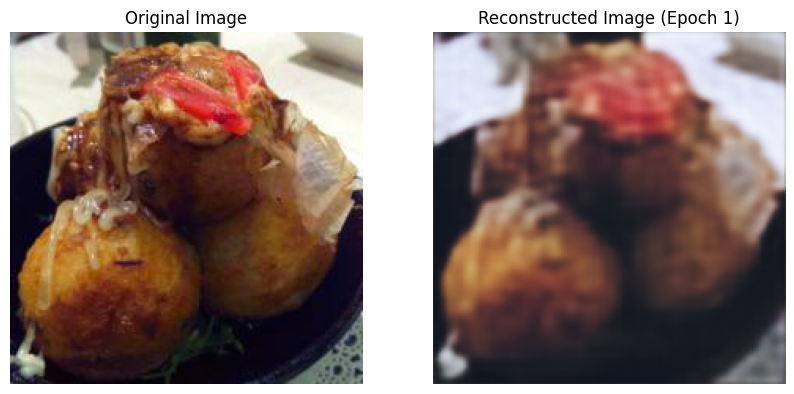

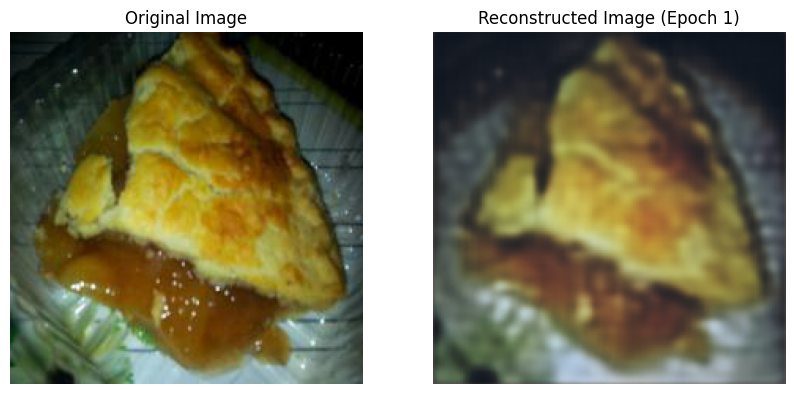

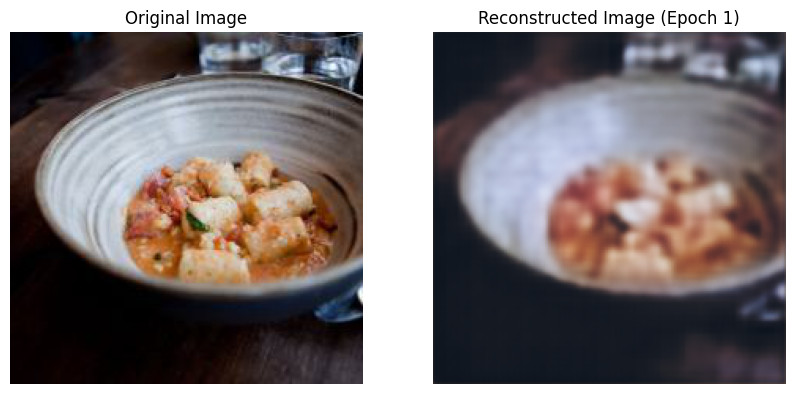

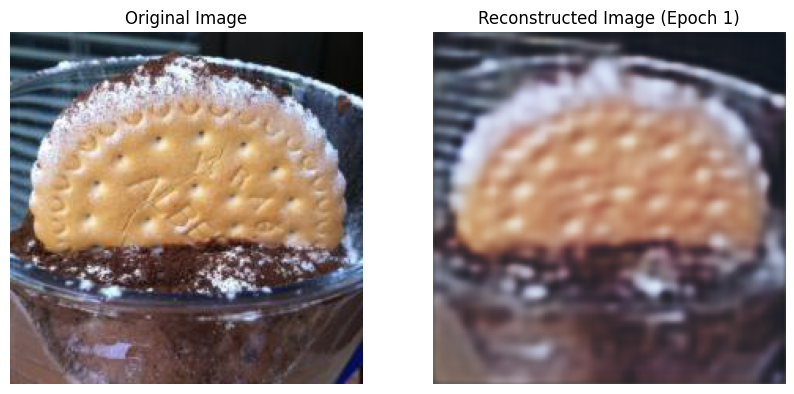

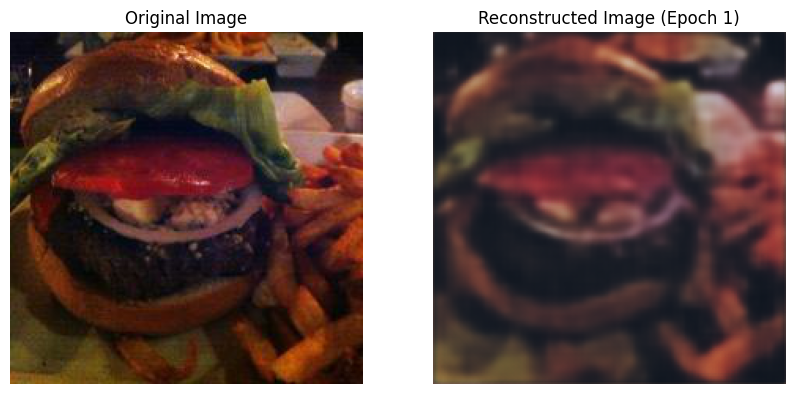

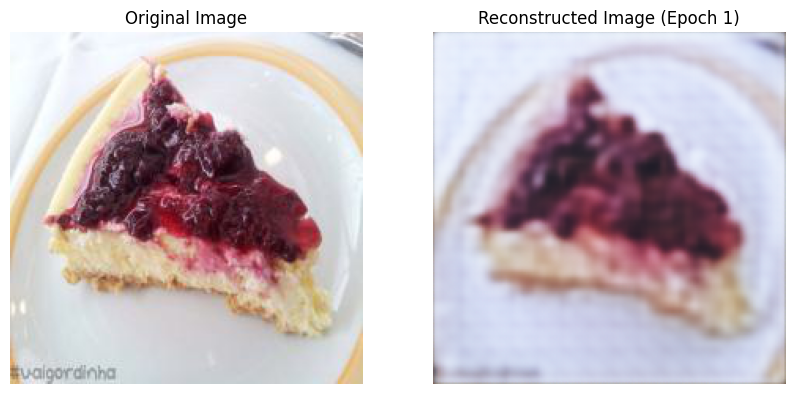

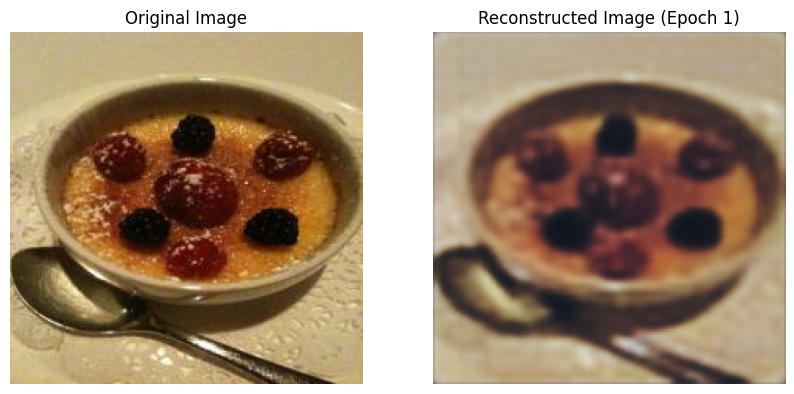

In [17]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()  # Modo de entrenamiento
        else:
            model.eval()  # Modo de evaluación

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        with tqdm(total=len(dataloaders[phase]), desc=f"{phase} phase") as pbar:
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    _, outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # Backward pass y optimización solo en entrenamiento
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                total_samples += inputs.size(0)
                
                pbar.set_postfix({"Loss": f"{running_loss / total_samples:.4f}"})
                pbar.update(1)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        print(f"{phase} Loss: {epoch_loss:.4f}")

        # Sincronizar GPU para evitar acumulación de operaciones pendientes
        torch.cuda.synchronize()

    # Display images passed through the autoencoder for visual evaluation
    with torch.no_grad():
        # First show a fixed image for continuous evaluation
        fixed_image = selected_image[0].unsqueeze(0).to(device)
        _, reconstructed_image = model(fixed_image)
        show_image(fixed_image[0], reconstructed_image[0], epoch)

        # Then some random images to see how other classes are doing
        for _ in range(0, amount_of_pictures_to_show):
            iterator = iter(dataloaders["test"])
            for _ in range(0, random.randrange(0, len(dataloaders["test"]) - 1)):
                next(iterator)
            image, _ = next(iterator)

            i = random.randrange(0, len(image))
            image = image[i].unsqueeze(0).to(device)
            _, reconstructed_image = model.forward(image)
            show_image(image[0], reconstructed_image[0], 0)

# Guardar el encoder para su uso posterior
torch.save(model.encoder.state_dict(), encoder_name)
torch.save(model.decoder.state_dict(), decoder_name)
torch.save(model.state_dict(), autoencoder_name)

# Training of the classification model

In [13]:
pretrained_encoder = Autoencoder().encoder
pretrained_encoder.load_state_dict(torch.load('encoder_1_epoch.pth'))
pretrained_encoder = pretrained_encoder.to(device)

model = Classifier(pretrained_encoder).to(device)
model.A()


train_loader = DataLoader(train_dataset, batch_size=classification_batch_size, shuffle=True, num_workers=workers)
test_loader = DataLoader(test_dataset, batch_size=classification_batch_size, shuffle=False, num_workers=workers)
dataloaders = {"train": train_loader, "test": test_loader}


BENINGIN
16
Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Dropout2d(p=0.3, inplace=False)
Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Dropout2d(p=0.3, inplace=False)
Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Dropout2d(p=0.3, inplace=False)
Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Dropout2d(p=0.3, inplace=False)
0.weight: False
0.bias: False
1.weight: False
1.bias: False
4.weight: False
4.bias: False
5.weight: False
5.bias: False
8.weight: False
8.bias: False
9.weight: False
9.bias: False
12.weight: True
12.bias: True
13.weight: True
13.bia

/tmp/ipykernel_342/1293089164.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_encoder.load_state_dict(torch.load('encoder_1_epoch.pth'))


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            with tqdm(total=len(dataloaders[phase]), desc=f"{phase} phase") as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    batch_acc = (torch.sum(preds == labels.data).item() / inputs.size(0)) * 100
                    pbar.set_postfix({"Loss": running_loss, "Accuracy": f"{batch_acc:.2f}%"})
                    pbar.update(1)
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    torch.save(model.encoder.state_dict(), 'classifier.pth') # classifier_name)

    return model

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=classification_learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
model = train_model(model, criterion, optimizer, scheduler, classification_epochs)

Epoch 0/19
----------


train phase: 100%|██████████| 592/592 [01:35<00:00,  6.23it/s, Loss=9.72e+5, Accuracy=0.98%]


train Loss: 12.8343 Acc: 0.0235


test phase: 100%|██████████| 198/198 [00:21<00:00,  9.16it/s, Loss=1.27e+5, Accuracy=0.00%] 


test Loss: 5.0258 Acc: 0.0476

Training complete in 1m 57s
Epoch 1/19
----------


train phase: 100%|██████████| 592/592 [01:27<00:00,  6.73it/s, Loss=3.57e+5, Accuracy=8.82%] 


train Loss: 4.7143 Acc: 0.0466


test phase: 100%|██████████| 198/198 [00:21<00:00,  9.16it/s, Loss=1.04e+5, Accuracy=2.94%] 


test Loss: 4.1284 Acc: 0.0892

Training complete in 3m 46s
Epoch 2/19
----------


train phase: 100%|██████████| 592/592 [01:28<00:00,  6.70it/s, Loss=3.22e+5, Accuracy=5.88%] 


train Loss: 4.2561 Acc: 0.0712


test phase: 100%|██████████| 198/198 [00:21<00:00,  9.36it/s, Loss=1.02e+5, Accuracy=2.94%] 


test Loss: 4.0267 Acc: 0.1039

Training complete in 5m 36s
Epoch 3/19
----------


train phase: 100%|██████████| 592/592 [01:28<00:00,  6.69it/s, Loss=3.14e+5, Accuracy=7.84%] 


train Loss: 4.1443 Acc: 0.0872


test phase: 100%|██████████| 198/198 [00:21<00:00,  9.41it/s, Loss=9.93e+4, Accuracy=0.00%] 


test Loss: 3.9321 Acc: 0.1211

Training complete in 7m 25s
Epoch 4/19
----------


train phase: 100%|██████████| 592/592 [01:29<00:00,  6.63it/s, Loss=3.09e+5, Accuracy=8.82%] 


train Loss: 4.0733 Acc: 0.0977


test phase: 100%|██████████| 198/198 [00:21<00:00,  9.13it/s, Loss=9.8e+4, Accuracy=2.94%]  


test Loss: 3.8799 Acc: 0.1269

Training complete in 9m 16s
Epoch 5/19
----------


train phase: 100%|██████████| 592/592 [01:29<00:00,  6.58it/s, Loss=3.04e+5, Accuracy=15.69%]


train Loss: 4.0184 Acc: 0.1073


test phase: 100%|██████████| 198/198 [00:21<00:00,  9.18it/s, Loss=9.73e+4, Accuracy=11.76%]


test Loss: 3.8535 Acc: 0.1336

Training complete in 11m 8s
Epoch 6/19
----------


train phase: 100%|██████████| 592/592 [01:30<00:00,  6.57it/s, Loss=3.01e+5, Accuracy=4.90%] 


train Loss: 3.9788 Acc: 0.1126


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.48it/s, Loss=9.58e+4, Accuracy=8.82%] 


test Loss: 3.7948 Acc: 0.1414

Training complete in 12m 59s
Epoch 7/19
----------


train phase: 100%|██████████| 592/592 [01:27<00:00,  6.73it/s, Loss=2.92e+5, Accuracy=16.67%]


train Loss: 3.8592 Acc: 0.1367


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.46it/s, Loss=9.43e+4, Accuracy=8.82%] 


test Loss: 3.7334 Acc: 0.1539

Training complete in 14m 48s
Epoch 8/19
----------


train phase: 100%|██████████| 592/592 [01:25<00:00,  6.89it/s, Loss=2.9e+5, Accuracy=16.67%] 


train Loss: 3.8299 Acc: 0.1407


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.64it/s, Loss=9.36e+4, Accuracy=8.82%] 


test Loss: 3.7059 Acc: 0.1582

Training complete in 16m 34s
Epoch 9/19
----------


train phase: 100%|██████████| 592/592 [01:25<00:00,  6.93it/s, Loss=2.88e+5, Accuracy=21.57%]


train Loss: 3.7982 Acc: 0.1457


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.63it/s, Loss=9.32e+4, Accuracy=8.82%] 


test Loss: 3.6892 Acc: 0.1610

Training complete in 18m 20s
Epoch 10/19
----------


train phase: 100%|██████████| 592/592 [01:25<00:00,  6.93it/s, Loss=2.86e+5, Accuracy=16.67%]


train Loss: 3.7773 Acc: 0.1499


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.54it/s, Loss=9.29e+4, Accuracy=8.82%] 


test Loss: 3.6801 Acc: 0.1637

Training complete in 20m 6s
Epoch 11/19
----------


train phase: 100%|██████████| 592/592 [01:26<00:00,  6.88it/s, Loss=2.84e+5, Accuracy=14.71%]


train Loss: 3.7525 Acc: 0.1522


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.51it/s, Loss=9.24e+4, Accuracy=8.82%] 


test Loss: 3.6603 Acc: 0.1677

Training complete in 21m 53s
Epoch 12/19
----------


train phase: 100%|██████████| 592/592 [01:24<00:00,  6.98it/s, Loss=2.83e+5, Accuracy=12.75%]


train Loss: 3.7369 Acc: 0.1565


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.76it/s, Loss=9.21e+4, Accuracy=8.82%] 


test Loss: 3.6487 Acc: 0.1705

Training complete in 23m 38s
Epoch 13/19
----------


train phase: 100%|██████████| 592/592 [01:24<00:00,  6.99it/s, Loss=2.81e+5, Accuracy=19.61%]


train Loss: 3.7131 Acc: 0.1611


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.80it/s, Loss=9.22e+4, Accuracy=8.82%] 


test Loss: 3.6532 Acc: 0.1698

Training complete in 25m 23s
Epoch 14/19
----------


train phase: 100%|██████████| 592/592 [01:24<00:00,  6.99it/s, Loss=2.79e+5, Accuracy=18.63%]


train Loss: 3.6825 Acc: 0.1633


test phase: 100%|██████████| 198/198 [00:19<00:00,  9.97it/s, Loss=9.17e+4, Accuracy=8.82%] 


test Loss: 3.6315 Acc: 0.1709

Training complete in 27m 8s
Epoch 15/19
----------


train phase: 100%|██████████| 592/592 [01:23<00:00,  7.08it/s, Loss=2.78e+5, Accuracy=13.73%]


train Loss: 3.6712 Acc: 0.1672


test phase: 100%|██████████| 198/198 [00:19<00:00,  9.98it/s, Loss=9.17e+4, Accuracy=8.82%] 


test Loss: 3.6318 Acc: 0.1723

Training complete in 28m 51s
Epoch 16/19
----------


train phase: 100%|██████████| 592/592 [01:23<00:00,  7.05it/s, Loss=2.78e+5, Accuracy=18.63%]


train Loss: 3.6672 Acc: 0.1670


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.81it/s, Loss=9.17e+4, Accuracy=8.82%] 


test Loss: 3.6297 Acc: 0.1732

Training complete in 30m 35s
Epoch 17/19
----------


train phase: 100%|██████████| 592/592 [01:24<00:00,  6.99it/s, Loss=2.78e+5, Accuracy=23.53%]


train Loss: 3.6683 Acc: 0.1674


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.76it/s, Loss=9.16e+4, Accuracy=8.82%] 


test Loss: 3.6284 Acc: 0.1718

Training complete in 32m 20s
Epoch 18/19
----------


train phase: 100%|██████████| 592/592 [01:24<00:00,  6.97it/s, Loss=2.78e+5, Accuracy=13.73%]


train Loss: 3.6657 Acc: 0.1710


test phase: 100%|██████████| 198/198 [00:20<00:00,  9.70it/s, Loss=9.15e+4, Accuracy=8.82%] 


test Loss: 3.6249 Acc: 0.1726

Training complete in 34m 6s
Epoch 19/19
----------


train phase: 100%|██████████| 592/592 [01:23<00:00,  7.06it/s, Loss=2.78e+5, Accuracy=15.69%]


train Loss: 3.6644 Acc: 0.1669


test phase: 100%|██████████| 198/198 [00:19<00:00,  9.98it/s, Loss=9.15e+4, Accuracy=8.82%] 

test Loss: 3.6225 Acc: 0.1740

Training complete in 35m 49s
